# Structure of an LSTM Cell

At each time step $t$, the LSTM takes:

 - Input vector: $x_t$

 - Previous hidden state: $h_{t-1}$

 - Previous cell state: $c_{t-1}$

and outputs:

 - New hidden state: $h_t$

 - New cell state: $c_t$

---

### Internally, it has gates. Each gate is basically:

**linear layer → sigmoid (or tanh) → elementwise operations**

---


Let’s define:

1. $\sigma$ = sigmoid function (outputs between 0 and 1)

2. tanh = hyperbolic tangent (outputs between -1 and 1)

3. $\odot$ = element-wise (Hadamard) product

4. $[h_{t-1}, x_t]$ = concatenation of $h_{t-1}$ and $x_t$

## **Gates and States**

1. ### Forget Gate – “What should I forget from the past?”

$$f_t = \sigma(W_f[h_{t-1},x_t] + b_f)$$

 If a component of $f_t$ is close to 0 → forget that part of cell state.
Close to 1 → keep it.

2. ### Input Gate – “What new information should I add?”

Two parts:

**Gate (how much to write):**

$$i_t = \sigma(W_i[h_{t-1},x_t] + b_i)$$

**Candidate new content (what to write):**

$$\tilde{c}_t = \tanh(W_c[h_{t-1},x_t] + b_c)$$

3. ### Update Cell State – combine forget + new info

$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$

This $c_t$ is the “memory” of the network.

4. ### Output Gate – “What part of the memory should I show as output?”

Gate:

$$o_t = \sigma(W_o[h_{t-1},x_t] + b_o)$$

Hidden state:

$$h_t = o_t \odot \tanh(c_t)$$

So cell state $c_t$ is like long-term memory,
and hidden state $h_t$ is what’s exposed to the next layer / output.

---


## Parameter Shapes (rough idea)

Assume:

 - Input dimension = input_size

 - Hidden dimension = hidden_ize

Then, for each gate:

$W_f, W_i, W_c, W_o$ have shape: (hidden_size, hidden_size + input_size)

$b_f, b_i, b_c, b_o$ have shape: (hidden_size,)

> So one LSTM cell has 4 sets of weights & biases (for 4 gates).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [11]:
# generate sine wave data
T = 1000 # total time steps
x = np.linspace(0, 8 * np.pi, T)
data = np.sin(x).astype(np.float32) # shape: (T,)

# turn into supervised data
seq_len = 20  # how many past steps we will use

X = []
Y = []

for i in range(T - seq_len):
    X.append(data[i:i+seq_len])
    Y.append(data[i+seq_len])

X = np.array(X)  # shape: (T-seq_len, seq_len)
Y = np.array(Y)  # shape: (T-seq_len)

# add feature dimension (input_size = 1)
X = X[:, :, None]
Y = Y[:, None]

# convert to torch tensor
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

print(X.shape, Y.shape)

torch.Size([980, 20, 1]) torch.Size([980, 1])


**Key point:**
PyTorch LSTM (with `batch_first=True`) expects input as:

> (batch_size, seq_len, input_size)

Here:
 - `batch_size = N` (number of sequences)
 - `seq_len = 20`
 - `input_size = 1` (just one feature per time step: the sine value)

In [12]:
"""
Input  x: (batch, seq, input)
↓
LSTM out: (batch, seq, hidden)
↓ select last time step
(batch, hidden)
↓
Linear layer → prediction
(batch, 1)

"""

'\nInput  x: (batch, seq, input)\n↓\nLSTM out: (batch, seq, hidden)\n↓ select last time step\n(batch, hidden)\n↓\nLinear layer → prediction\n(batch, 1)\n\n'

In [13]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # input/output shape: (batch, seq, feature)
        )

        # Final fully-connected layer to map hidden state -> prediction
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)

        # Let PyTorch initialize h0, c0 as zeros automatically if we don't pass them,
        # OR we can do it manually like this:
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        # out: (batch, seq_len, hidden_size)
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # We only care about the LAST time step's output for prediction
        last_out = out[:, -1, :]   # shape: (batch, hidden_size)

        # Map to final output (batch, 1)
        out = self.fc(last_out)
        return out


In [14]:
model = SimpleLSTM(input_size=1, hidden_size=32, num_layers=1)

criterion = nn.MSELoss()          # because it's a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [15]:
num_epochs = 20
batch_size = 32

for epoch in range(num_epochs):
    permutation = torch.randperm(X.size(0))
    epoch_loss = 0.0

    for i in range(0, X.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X[indices]      # shape: (batch_size, seq_len, 1)
        batch_y = Y[indices]      # shape: (batch_size, 1)

        # Forward pass
        outputs = model(batch_x)  # (batch_size, 1)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/20], Loss: 3.3264
Epoch [2/20], Loss: 0.1219
Epoch [3/20], Loss: 0.0295
Epoch [4/20], Loss: 0.0110
Epoch [5/20], Loss: 0.0049
Epoch [6/20], Loss: 0.0025
Epoch [7/20], Loss: 0.0009
Epoch [8/20], Loss: 0.0008
Epoch [9/20], Loss: 0.0003
Epoch [10/20], Loss: 0.0004
Epoch [11/20], Loss: 0.0003
Epoch [12/20], Loss: 0.0004
Epoch [13/20], Loss: 0.0009
Epoch [14/20], Loss: 0.0008
Epoch [15/20], Loss: 0.0004
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0002
Epoch [19/20], Loss: 0.0001
Epoch [20/20], Loss: 0.0002


In [16]:
model.eval()
with torch.no_grad():
    sample_x = X[0:1]                 # take the first sequence, shape: (1, seq_len, 1)
    true_y = Y[0].item()

    pred_y = model(sample_x).item()

    print("True next value:     ", true_y)
    print("Predicted next value:", pred_y)


True next value:      0.48219454288482666
Predicted next value: 0.4845336079597473


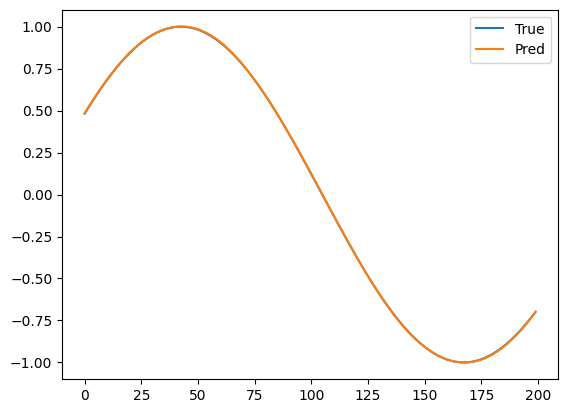

In [17]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    preds = model(X).squeeze().numpy()
    true = Y.squeeze().numpy()

plt.plot(true[:200], label="True")
plt.plot(preds[:200], label="Pred")
plt.legend()
plt.show()


### Perfectly overlapped !!